### K-Mean Clustering

Apply K-means clustering on online retail transactional data applying RFM clustering approach.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for scaling data
from sklearn.preprocessing import scale

# for kmeans
from sklearn.cluster import KMeans

# for heirachica clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Data
retail_df = pd.read_csv("Online+Retail.csv", sep = ",", encoding = "ISO-8859-1", header = 0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# parsing the InvoiceDate to date
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format = "%d-%m-%Y %H:%M")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(retail_df.shape)
retail_df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Missing values
missing = retail_df.isnull().mean()*100
missing

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

There is about 25% of missing values in customer ID and and a small amount in Description. Since, customerID is a unique identifier, we cannot fill missing values for it as there may be information on same customerID multiple times. So, we will drop all the missing records.

In [6]:
# drop missing values
retail_df = retail_df.dropna()

#check the missing values
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Extracting R(Recency), F(Frequency) and M(Monetary) from the data

In [7]:
# Amount spent on each transaction
retail_df['Amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [8]:
# Monetary
# calculate the total amount spent by each customer 
Monetary = retail_df.groupby('CustomerID')['Amount'].sum()
Monetary = Monetary.reset_index()
Monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# Frequency
# how frequent(number of transactions) has a customer purchased
Frequency = retail_df.groupby('CustomerID').size().reset_index(name = 'Frequency')
Frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
# Recency Value
# how long is the last transaction made by a customer
Recency = retail_df[['CustomerID','InvoiceDate']]

# Finding the recent date
recent = max(retail_df.InvoiceDate)

# Adding 1 more day to the recent so that the latest date will alos have a 1 day difference and not 0
recent = recent+pd.DateOffset(days = 1)

# calculate the difference between the recent date and the last date of transaction 
Recency['diff'] = recent - Recency.InvoiceDate

Recency.head()

C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [11]:
# to get the latest date of transaction for a customer, we take the minium of diff
Recency = Recency.groupby('CustomerID').diff.min().reset_index(name = 'Recency')
Recency.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [12]:
# combine Recency, Frequecy and Monetary
RFM_df = pd.merge(Monetary, Frequency, on = 'CustomerID', how = 'inner')
RFM_df = RFM_df.merge(Recency, on = 'CustomerID', how = 'inner')
RFM_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


#### Outlier Treatment
Kmeans is highly sensitive to outlier, so we must treat the outliers.

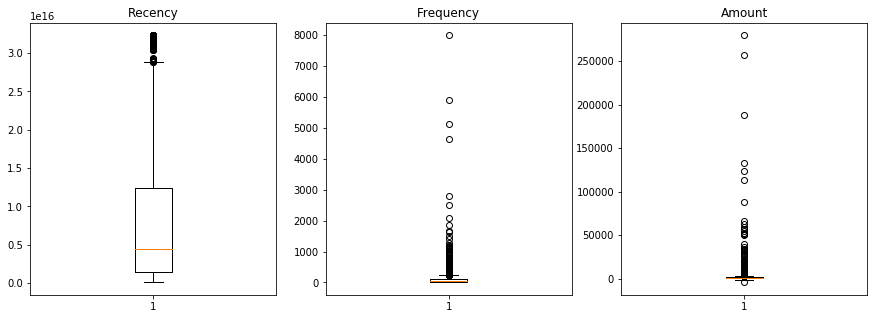

In [13]:
# box plots
plt.figure(figsize = (15,5))

for i, var in enumerate(['Recency', 'Frequency', 'Amount']):
    plt.subplot(1,3,i+1)
    plt.boxplot(RFM_df[var])
    plt.title(var)
    

We can see all the three variables have outliers. We will remove the outliers using quartile method.

In [14]:
for var in ['Recency','Frequency','Amount']:
    Q1 = RFM_df[var].quantile(0.25)
    Q3 = RFM_df[var].quantile(0.75)
    IQR = Q3 - Q1
    RFM_df = RFM_df[(RFM_df[var] >= Q1- (1.5*IQR)) & (RFM_df[var] <= Q3+(1.5*IQR))]
    

In [15]:
RFM_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00
5,12352.0,1545.41,95,36 days 22:13:00


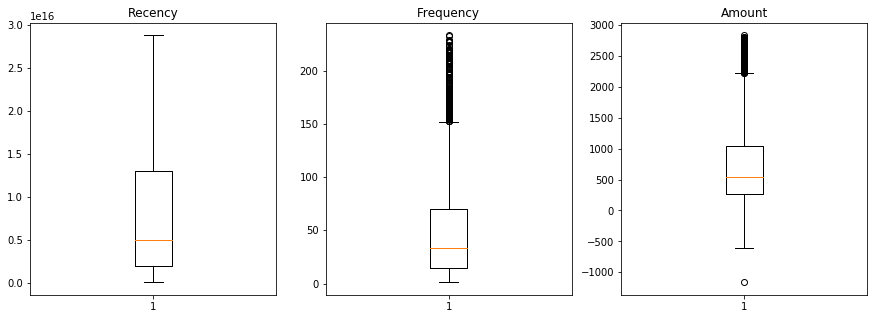

In [16]:
# rechecking the outliers
plt.figure(figsize = (15,5))

for i, var in enumerate(['Recency', 'Frequency', 'Amount']):
    plt.subplot(1,3,i+1)
    plt.boxplot(RFM_df[var])
    plt.title(var)
    

Now, we see the distribution of Frequency and Amount is more spread out than before.

#### Standardising the data

In [17]:
from sklearn.preprocessing import StandardScaler

# drop the customerID
RFM_scaled = RFM_df.drop('CustomerID', axis = 1)

# convert the Recency columns to days(float)
RFM_scaled['Recency'] = RFM_scaled['Recency'].dt.days

scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM_scaled)

RFM_scaled = pd.DataFrame(RFM_scaled, columns=['Amount','Frequency','Recency'])

RFM_scaled.head()

C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Amount,Frequency,Recency
0,-1.153622,-1.026513,2.536426
1,1.617682,-0.402322,-0.203569
2,1.556481,0.501680,-0.814882
3,-0.637985,-0.703655,2.361765
4,1.229366,0.975205,-0.629305


### Hopkins Test

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [18]:
# function for hopkins test

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [19]:
hopkins(RFM_scaled)

0.900451356325171

Since, we have a high hopkins value, the data is highly suitable for clustering.

### KMeans Clustering

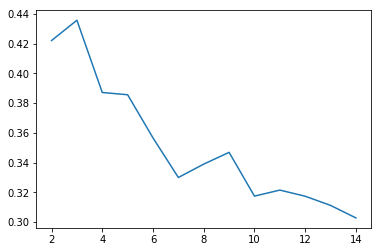

In [20]:
from sklearn.metrics import silhouette_score

# slecting optimal number of clusters with the silhouette score
sil_score = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k).fit(RFM_scaled)
    sil_score.append(silhouette_score(RFM_scaled, kmeans.labels_))
    
plt.plot(range(2,15), sil_score)

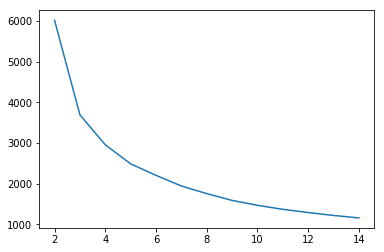

In [21]:
# optimal cluster with sum of squared distances
ss_dis = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k).fit(RFM_scaled)
    ss_dis.append(kmeans.inertia_)

plt.plot(range(2,15), ss_dis)

From both the cases we can see that the optimal number of clusters is 3, as silhouette_score is maximum at k = 3 and the elbow point can be seen at k = 3 with sum of squared distances. 

In [22]:
# Kmeans at k = 3

kmean_model = KMeans(n_clusters=3,max_iter=50)
kmean_model.fit(RFM_scaled)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
kmean_model.labels_

array([1, 2, 2, ..., 1, 0, 2])

In [24]:
# Adding the cluster labels to the RFM data
RFM_df['Cluster_ID'] =  kmean_model.labels_

#convert Recency to days
RFM_df.Recency = RFM_df.Recency.dt.days
RFM_df.head()


,CustomerID,Amount,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,326,1
2,12348.0,1797.24,31,75,2
3,12349.0,1757.55,73,19,2
4,12350.0,334.40,17,310,1
5,12352.0,1545.41,95,36,2


In [25]:
# Claculate the averages of all the variables for the clusters
cluster_summary = RFM_df.drop('CustomerID', axis = 1)
cluster_summary = cluster_summary.groupby('Cluster_ID').agg('mean').reset_index()
cluster_summary

,Cluster_ID,Amount,Frequency,Recency
0,0,545.210453,34.059815,48.364872
1,1,361.474895,22.900772,230.179713
2,2,1658.716541,116.417610,42.631447


Text(0.5,1,'Average Frequency')

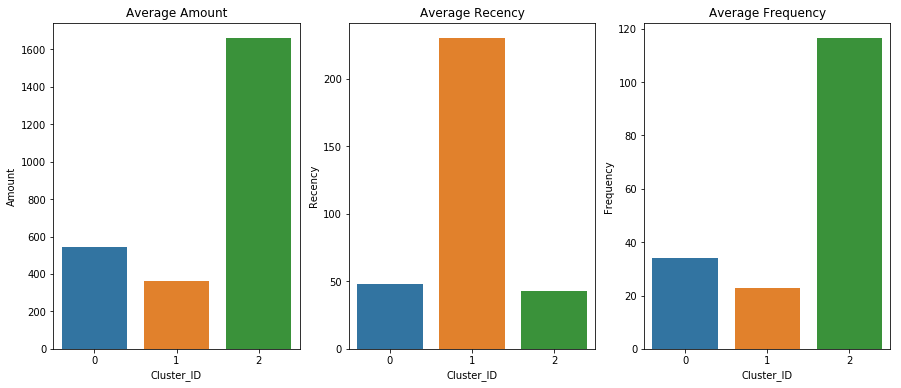

In [26]:
import seaborn as sns

plt.figure(figsize = (15,6))

plt.subplot(1,3,1)
sns.barplot(x = cluster_summary.Cluster_ID, y = cluster_summary.Amount)
plt.title('Average Amount')

plt.subplot(1,3,2)
sns.barplot(x = cluster_summary.Cluster_ID, y = cluster_summary.Recency)
plt.title('Average Recency')

plt.subplot(1,3,3)
sns.barplot(x = cluster_summary.Cluster_ID, y = cluster_summary.Frequency)
plt.title('Average Frequency')

Here, we can see that cluster 2, third cluster is the best as they spend high amount on transactions, they have low recency, which means they are active and also have very high frequency, which tells they shop very frequently. Similarly, cluster 0, first cluster seems to be averge customers. Cluster 1, second cluster spend very less and are inactive and also shop less frequetly.

#### Heirachical Clustering

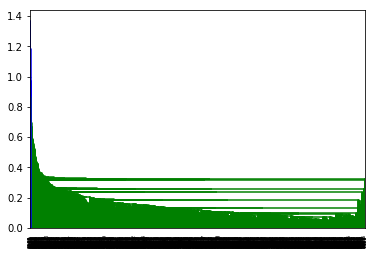

In [27]:
hc = linkage(RFM_scaled, method = "single", metric='euclidean')
dendrogram(hc)
plt.show()

Here, we can see that the single linkage method is not performing good, lets try the complete linkage method.

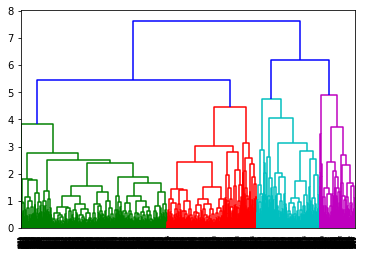

In [28]:
hc = linkage(RFM_scaled, method = 'complete', metric = 'euclidean')
dendrogram(hc)
plt.show()

Now, it looks much better. Also, we can see there are four cluster, but to compare with kmeans lets take three clusters.

In [29]:
hc_clusters = cut_tree(hc,n_clusters=3)
hc_clusters = hc_clusters.reshape(-1,)
hc_clusters

array([0, 1, 1, ..., 0, 0, 1])

In [30]:
# Now again lets add the hc labels to RFM data

RFM_df['HC_cluster'] =  hc_clusters

RFM_df.head()


,CustomerID,Amount,Frequency,Recency,Cluster_ID,HC_cluster
0,12346.0,0.00,2,326,1,0
2,12348.0,1797.24,31,75,2,1
3,12349.0,1757.55,73,19,2,1
4,12350.0,334.40,17,310,1,0
5,12352.0,1545.41,95,36,2,2


In [31]:
# summarise the HC clusters
HC_summary = RFM_df.drop('CustomerID', axis = 1)
HC_summary =HC_summary.groupby('HC_cluster').agg('mean').reset_index()
HC_summary

,HC_cluster,Amount,Frequency,Recency,Cluster_ID
0,0,419.571992,29.069572,116.534186,0.395842
1,1,1807.679599,61.764706,54.561497,1.275401
2,2,1387.023544,120.354354,29.654655,1.546547


Text(0.5,1,'Average Frequency')

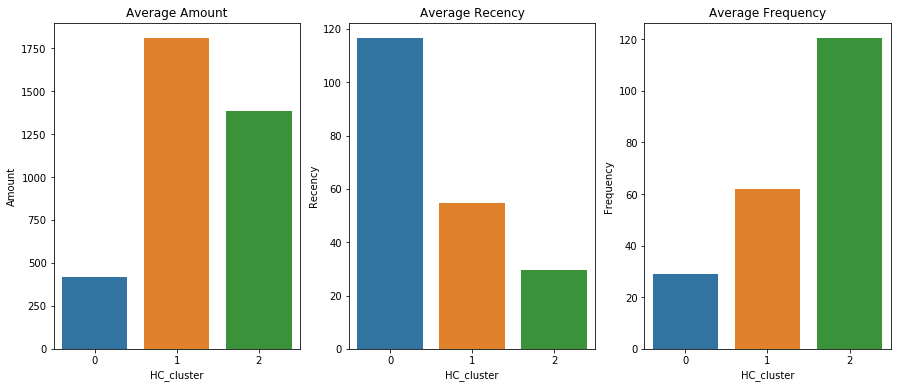

In [32]:
plt.figure(figsize = (15,6))

plt.subplot(1,3,1)
sns.barplot(x = HC_summary.HC_cluster, y = HC_summary.Amount)
plt.title('Average Amount')

plt.subplot(1,3,2)
sns.barplot(x = HC_summary.HC_cluster, y = HC_summary.Recency)
plt.title('Average Recency')

plt.subplot(1,3,3)
sns.barplot(x = HC_summary.HC_cluster, y = HC_summary.Frequency)
plt.title('Average Frequency')

Here, we see a bit different pattern. In Kmeans one of the cluster was way better than other two, here we can see cluster 1 and 2 are a bit similar in terms of amount spent, but cluster two is very inactive than cluster 1 and also has less frequency.